In [ ]:
from keras.datasets import imdb
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers, losses, metrics, optimizers
from keras.utils.vis_utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import numpy as np
import os
import re
import string
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Must Run This Cell Before Using The Pre-Processing:
! python3 -c "import nltk; nltk.download('all')"

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

However, the raw [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz ) is just plain text:

In [ ]:
from pathlib import Path
import os
DATA_PATH=Path('./dat/')
DATA_PATH.mkdir(exist_ok=True)
#if not os.path.exists('./dat/aclImdb_v1.tar.gz'):
if not os.path.exists('./dat/aclImdb'):
  !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
  !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

In [ ]:
# 'neg', 'pos' <-- ولكن احنا هنشتغل بس علي الاتنين دول unsupervised و negative و  positive اللي هم  classes 3 عندنا عباره عن labels ال
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./dat/aclImdb/')          # ./dat/aclImdb/ فبالتالي بقي عندي الداتا المسار بتاعها هو aclImdb فوق وحملت فيه الداتا بتاعتنا اللي اسمها dat اللي فيه الداتا بتاعتنا لاني انا عملت فولدر اسمه Path ده كده خلاص ال

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):             # index = 1 ب pos وال index = 0 ب neg ال enumerate هطبعا انا عامل عن طريق ال  /dat/aclImdb/pos وفولدر /dat/aclImdb/neg فأنا بعمل فور لوب بحيث يدخلي علي فولدر pos و neg الداتا اصلا محطوطه في فولدرين اللي هم
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())       # labels اللي هي 0 & 1 في الليست اللي اسمها labels ال append وهي texts في الليست اللي اسمها neg & pos ال texts ال append فهو هنا كدا هي
            labels.append(idx)
    #return np.array(texts),np.array(labels)
    return texts, labels


In [ ]:
# /dat/aclImdb/test/neg و /dat/aclImdb/test/pos و /dat/aclImdb/train/neg و /dat/aclImdb/train/pos  <-- مثل الاتي paths فبالتالي هيبق عندي test و train هنا هو هيفضي الفانكشن اللي فوق دي في فولدرين ال 
train_texts,train_labels = get_texts(PATH/'train')
test_texts,test_labels = get_texts(PATH/'test')

In [ ]:
# pre-processing دي كده فانكشن كبيره بتعملي كل اللي انا عاملته فوق كله يعني بتعملي كل ال
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def to_lowercase(text):
    return text.lower()


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def text2words(text):
  return word_tokenize(text)


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])


def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    text = remove_whitespaces(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)            # ''.join(words)  -->  Prepration وهرجع اضمهم تاني عشان اعمل ال pre-processing فأنا فكتهم عشان اعمل  tokens تاني مع بعض عشان يرجعوا جمل تاني زي الاول قبل ما افكهم ل tokens دي عشان يضملي ال


In [ ]:
# pre-processing وهعمل عليها ال train_texts هنا انا همسك جمله جمله من ال  

def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]
train_texts = normalize_corpus(train_texts)

In [ ]:
# pre-processing وهعمل عليها ال test_texts هنا انا همسك جمله جمله من ال  

def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]
test_texts = normalize_corpus(test_texts)

In [ ]:
train= pd.DataFrame({'review': train_texts, 'label': train_labels})
test= pd.DataFrame({'review': test_texts, 'label': test_labels})

In [ ]:
train.head()

,review,label
0,face ruiz set make psychological thriller alth...,0
1,catogoricaly unequivocally say year planet wor...,0
2,subject atrocity wife try turn minute force wh...,0
3,ill admit dont expect much roger corman film g...,0
4,worst movie history cinema dont know try funny...,0


In [ ]:
train['label'].value_counts() 

0    12500
1    12500
Name: label, dtype: int64

In [ ]:
train.isna().sum()

review    0
label     0
dtype: int64

In [ ]:
from IPython.display import Markdown, display                 # دي كدا طريقه لعرض اول خمس تعليقات من الناس بطريقه منظمه
for i in range(5):
    display(Markdown('> '+ train['review'][i]))
    print('--------------------------------------')

> face ruiz set make psychological thriller although satisfy classic piece genre compensation tension generate huppert balibar woman calmly calculatingly war boy claim compel however true european arthouse style ruiz doesnt give u release tension woman alternately also try behave compassionately towards raise voice hupperts wake nightmare uncontested irrational event film fact follow title film little thriller skeleton jane campion cut instead intergender psychological study focus men boy camille nil hugon decide practical joke play mother emotionally vulnerable woman woman seem pander rather scold compound problem background intemperate psychologist charles berling swift confront woman life sister huppert nanny pa act symbolic adult counterbalance calm learn manipulative camille particularly interest like father henry jam turn screw denis podalydes lawenforcer father absent duration film ruiz fashion oedipal moment hupperts reaction return film close read either thriller psychiatric essay film ultimately rather disappoint im officially rather feed mme hupperts screen method bury ill look see stage come back european enjoy heaven gate film support good ruiz cast favour though quite apart poor light wilfully odd shoot direction leave characterisation quite reach im think particularly edith scobs shamanic neighbour isabelle act know communicate bafflement set piece link forward drive plot tension already refer weakly dissipate waste directional potential want see good contemporary french thriller go see lappartement instead

--------------------------------------


> catogoricaly unequivocally say year planet worse supposibly childrens film ever see life take three grand child see even struggle raise smile tortuous min sexual indendoes leave another day tasteless film pay watch pay truly truly awful way describe people make film bring task take money false pretence aplogise spell mistake upset spoil time grandchild regard stephen

--------------------------------------


> subject atrocity wife try turn minute force whole thing must hand gruesome pretense movie ever great script moment sammy get right away get bonus madam boner sammy bonus summarize horrible script terrible act incredibly illogical

--------------------------------------


> ill admit dont expect much roger corman film generally expect lot walk bad script yet case pleasantly surprise gunslinger story woman play spunky beverly garland take sheriff husband brutally murder m garland pretty good shoot kill one murderer next day husband funeral first task shut local bar violate town curfew bar owner try buy land anticipation buy hopedfor railroad however m garland thorn plan bar matron hire man kill m garland m garland play role honestly realistically absolutely temptation go suzanne somers shes sheriff joke exception couple faux pa apartment door open inside jeep track two horseman wait screen cue ride around corner movie become quite passable movie fare however corman could resist pad film horse rid scene much like walk film sterno say gunslinger horse opera worth time

--------------------------------------


> worst movie history cinema dont know try funny sad poignant droll end result unwatchable everyone key grip robin williams back best boy ashamed part film

--------------------------------------


In [ ]:
# اللي بعد دي cell وهشوف ايه التعليق اللي مش موجود يعني فاضي عشان نحذفه في ال [review] ان هنا هلوب علي العامود بتاع التعليقات
blanks = []

for i,lb,rv in train.itertuples():          # [i --> index], [lb --> label], [rv --> review],
    if type(rv)==str:                    # blanks في الليست  append بتاع التعليق ده index ولو كان فوسط التعليق في مسافات روح اعمل لل str ف انا هنا بقوله لو التعليق كان من النوع 
        if rv.isspace():         
            blanks.append(i)     
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [ ]:
test.head()

,review,label
0,thats say something matter bad movie get im no...,0
1,irritate thing dy dagost august day simply not...,0
2,big fan spielbergcruise version film must thro...,0
3,really far worst movie ive ever see whole life...,0
4,buy film ebay part lot twenty horror flick dol...,0


In [ ]:
test['label'].value_counts() 

0    12500
1    12500
Name: label, dtype: int64

In [ ]:
test.isna().sum()

review    0
label     0
dtype: int64

In [ ]:
from IPython.display import Markdown, display                 # دي كدا طريقه لعرض اول خمس تعليقات من الناس بطريقه منظمه
for i in range(5):
    display(Markdown('> '+ test['review'][i]))
    print('--------------------------------------')

> thats say something matter bad movie get im normally able sit judge full movie one make minute maybe dvd maybe laptop could hear dialogue even volume turn way sound effect fine volume turn hear dialogue blow eardrum effect much want see thing wasnt go sacrifice hear little could tell plot movie one big flashback main character daughter seem mother military pilot flee ship one person ship trust turn one enemy pursue across desert planet thing like movie look main character something like hairstyle oh well look like one go dumpster

--------------------------------------


> irritate thing dy dagost august day simply nothing happen film director marc recha nerve pretend film sort homage leftist catalan journalist ramon barnils unless mention barnils name time constitute homage pretense utter fraud learn virtually nothing barnils film spanish civil war special role catalunya war also learn collective punishment inflict heroic catalan people year afterward victorious vindictive franco footage catalan countryside beautiful course dy dagost extensive vary enough collection scene qualify travelogue large number still show illuminate image forest floor example clearest indication paucity idea aimless drift brother marc david camp trip produce compel cinema contrary one strongest impression film make spacedout middleaged hippy dont waste time read good book spanish civil war instead recommend felix morrow scathingly antistalinist revolution counterrevolution spain contain grip account barcelona uprise barry free

--------------------------------------


> big fan spielbergcruise version film must throw humble latthowel version c thomas howel heart sympathy cruise lead role least opinion hard imagine strip away everything thing spielberg version cost thousand dollar would nothing leave special effect set cruise doubt anything cost cool grand david michael latt version compare apple turnip guess go turnip least give independent movie shoot epic science fiction disaster market

--------------------------------------


> really far worst movie ive ever see whole life im approach description back cover equal scroll text right begin movie plot nil even bunch corps would show life act view full length really relieve final character death signal end suffer location either kind vault grimy beach suppose homevideo equipment serve camera light substandard dialogue uninspired devoid mean actor face bring topic makeup look get gimmick teenager magazine first makeup similar make buy dvd name lovecraft print cover connection brilliant mind work use name necronomicon wrongly translate book light euro pay dvd complete loss dvd go recycle box without ado

--------------------------------------


> buy film ebay part lot twenty horror flick dollar piece watch first impression probably late later begin think linkin park poster wall everything else seem hint deal recent film realize flick become unbearable torment last minute longest movie history film refuse end genre horror child case film definitely parent perverse enough want introduce offspring horror suggest would perfect kid thing really like greg cipes much good actor kind nostalgic retro bottom part drivein doublebill

--------------------------------------


In [ ]:
# اللي بعد دي cell وهشوف ايه التعليق اللي مش موجود يعني فاضي عشان نحذفه في ال [review] ان هنا هلوب علي العامود بتاع التعليقات
blanks = []

for i,lb,rv in test.itertuples():          # [i --> index], [lb --> label], [rv --> review],
    if type(rv)==str:                    # blanks في الليست  append بتاع التعليق ده index ولو كان فوسط التعليق في مسافات روح اعمل لل str ف انا هنا بقوله لو التعليق كان من النوع 
        if rv.isspace():         
            blanks.append(i)     
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [ ]:
X_train= train['review']
y_train= train['label']
X_test= test['review']
y_test= test['label']

## TfidfVectorizer

In [ ]:
# I will make to models  [naive_bayes & Linear Support Vector Classifier]
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),])

text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),])


In [ ]:
text_clf_nb.fit(X_train, y_train)
nb_predictions = text_clf_nb.predict(X_test)

 TN: 10988 
 FP: 1512 
 FN: 2801 
 TP: 9699


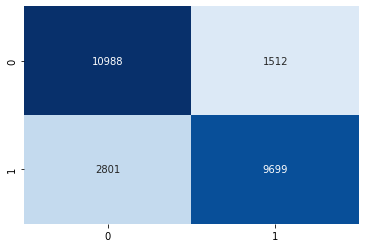

In [ ]:
from sklearn import metrics

confus_model= metrics.confusion_matrix(y_test, nb_predictions)
sns.heatmap(confus_model, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')


tn, fp, fn, tp = metrics.confusion_matrix(y_test, nb_predictions).ravel()
print(f' TN: {tn} \n FP: {fp} \n FN: {fn} \n TP: {tp}')

In [ ]:
print(metrics.classification_report(y_test, nb_predictions))
print('=============================')

print(metrics.accuracy_score(y_test, nb_predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     12500
           1       0.87      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

0.82748


In [ ]:
text_clf_lsvc.fit(X_train, y_train)
svc_predictions = text_clf_lsvc.predict(X_test)

 TN: 11034 
 FP: 1466 
 FN: 1781 
 TP: 10719


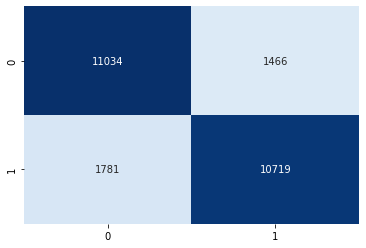

In [ ]:
from sklearn import metrics

confus_model= metrics.confusion_matrix(y_test, svc_predictions)
sns.heatmap(confus_model, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')


tn, fp, fn, tp = metrics.confusion_matrix(y_test, svc_predictions).ravel()
print(f' TN: {tn} \n FP: {fp} \n FN: {fn} \n TP: {tp}')

In [ ]:
print(metrics.classification_report(y_test, svc_predictions))
print('=============================')

print(metrics.accuracy_score(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

0.87012


In [ ]:
print(text_clf_lsvc.predict(['this product is very good']))

[1]


In [ ]:
print(text_clf_lsvc.predict(['big fan spielbergcruise version film must throw humble latthowel version c thomas howel heart sympathy cruise lead role least opinion hard imagine strip away everything thing spielberg version cost thousand dollar would nothing leave special effect set cruise doubt anything cost cool grand david michael latt version compare apple turnip guess go turnip least give independent movie shoot epic science fiction disaster market']))

[0]


## CountVectorizer

 TN: 10983 
 FP: 1517 
 FN: 2972 
 TP: 9528


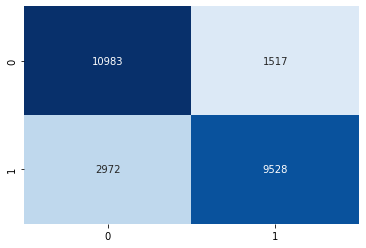

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 TN: 10685 
 FP: 1815 
 FN: 2222 
 TP: 10278


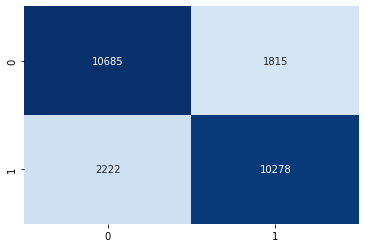

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


 TN: 10856 
 FP: 1644 
 FN: 1851 
 TP: 10649


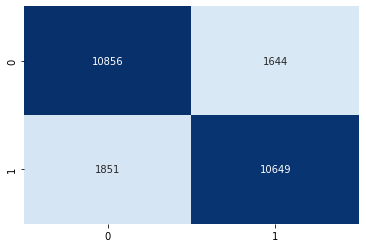

In [95]:
# I will make to models  [naive_bayes & Linear Support Vector Classifier, LogisticRegression] in CountVectorizer():
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics

text_clf_nb = Pipeline([('count', CountVectorizer()),
                     ('clf', MultinomialNB()),])

text_clf_lsvc = Pipeline([('count', CountVectorizer()),
                     ('clf', LinearSVC()),])

text_clf_linear = Pipeline([('count', CountVectorizer()),
                     ('clf', LogisticRegression()),])



models= [text_clf_nb, text_clf_lsvc, text_clf_linear]
for model in(models):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
  print(f' TN: {tn} \n FP: {fp} \n FN: {fn} \n TP: {tp}')
   
  confus_model= metrics.confusion_matrix(y_test, y_pred)
  sns.heatmap(confus_model, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')
  plt.show()


Accuracy is 0.8602
 TN: 10856 
 FP: 1644 
 FN: 1851 
 TP: 10649


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


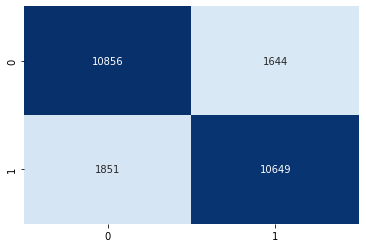

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [99]:
# The same CountVectorizer LogisticRegression model without Pipeline:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train= train['review']
y_train= train['label']
X_test= test['review']
y_test= test['label']

vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predictions= classifier.predict(X_test)

score = classifier.score(X_test, y_test)
print('Accuracy is {:.4f}'.format(score))


# confusion matrix:
confus_model= metrics.confusion_matrix(y_test, predictions)
sns.heatmap(confus_model, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')

tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
print(f' TN: {tn} \n FP: {fp} \n FN: {fn} \n TP: {tp}')
plt.show()

# Report:
print(metrics.classification_report(y_test, predictions))